In [125]:
!git clone https://github.com/AntonioSkara132/LangPathModel.git

Cloning into 'LangPathModel'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 152 (delta 67), reused 85 (delta 27), pack-reused 0 (from 0)
Receiving objects: 100% (152/152), 32.99 MiB | 12.97 MiB/s, done.
Resolving deltas: 100% (67/67), done.


# 1. Loading Dataset

In [158]:
import torch
import torch.utils

from torch.nn.utils.rnn import pad_sequence

from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

scale = 1000

class CirclePathDataset(Dataset):
    def __init__(self, file_path):
        # Load the data from the .pt file
        self.data = torch.load(file_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the path tensor and the text for the given index
        path_tensor = self.data[idx]['path'] / scale
        text = self.data[idx]['text']
        return path_tensor, text


from torch.nn.utils.rnn import pad_sequence
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def collate_fn(batch):
    # Unzip the batch into paths and texts
    paths, texts = zip(*batch)

    # Pad the paths (ensure they're all the same length)
    padded_paths = pad_sequence(paths, batch_first=True, padding_value=0)  # Padding value can be set to 0

    encoded = tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        return_tensors='pt'
    )

    return padded_paths, encoded


# Instantiate the dataset
dataset = CirclePathDataset("/content/LangPathModel/data/circle_in_the middle.pt")

# Create a DataLoader with the custom collate_fn

# 2. Visualizing Dataset

In [159]:
import torch
import numpy as np

# Assuming you already loaded your dataset
dataset = CirclePathDataset("/content/LangPathModel/data/circle_in_the middle.pt")

# Containers for analysis
path_lengths = []
positions = []
actions = []
stops = []

for path, _ in dataset:
    path_lengths.append(path.shape[0])  # Sequence length
    path_np = path.numpy()

    positions.extend(path_np[:, :2])  # x, y
    actions.extend(path_np[:, 2])      # a
    stops.extend(path_np[:, 3])      # s

positions = np.array(positions)
actions = np.array(actions)
stops = np.array(stops)

# Summary stats
print(f"Number of samples: {len(dataset)}")
print(f"Avg. path length: {np.mean(path_lengths):.2f}")
print(f"Max path length: {np.max(path_lengths)}")
print(f"Min path length: {np.min(path_lengths)}")
print(f"Position X: mean={positions[:,0].mean():.2f}, std={positions[:,0].std():.2f}")
print(f"Position Y: mean={positions[:,1].mean():.2f}, std={positions[:,1].std():.2f}")
print(f"Actions (a): mean={actions.mean():.2f}, std={actions.std():.2f}")
print(f"Stop (s): mean={stops.mean():.2f}, std={stops.std():.2f}")


Number of samples: 10000
Avg. path length: 85.23
Max path length: 92
Min path length: 80
Position X: mean=0.50, std=0.09
Position Y: mean=0.50, std=0.09
Actions (a): mean=0.00, std=0.00
Stop (s): mean=0.00, std=0.00


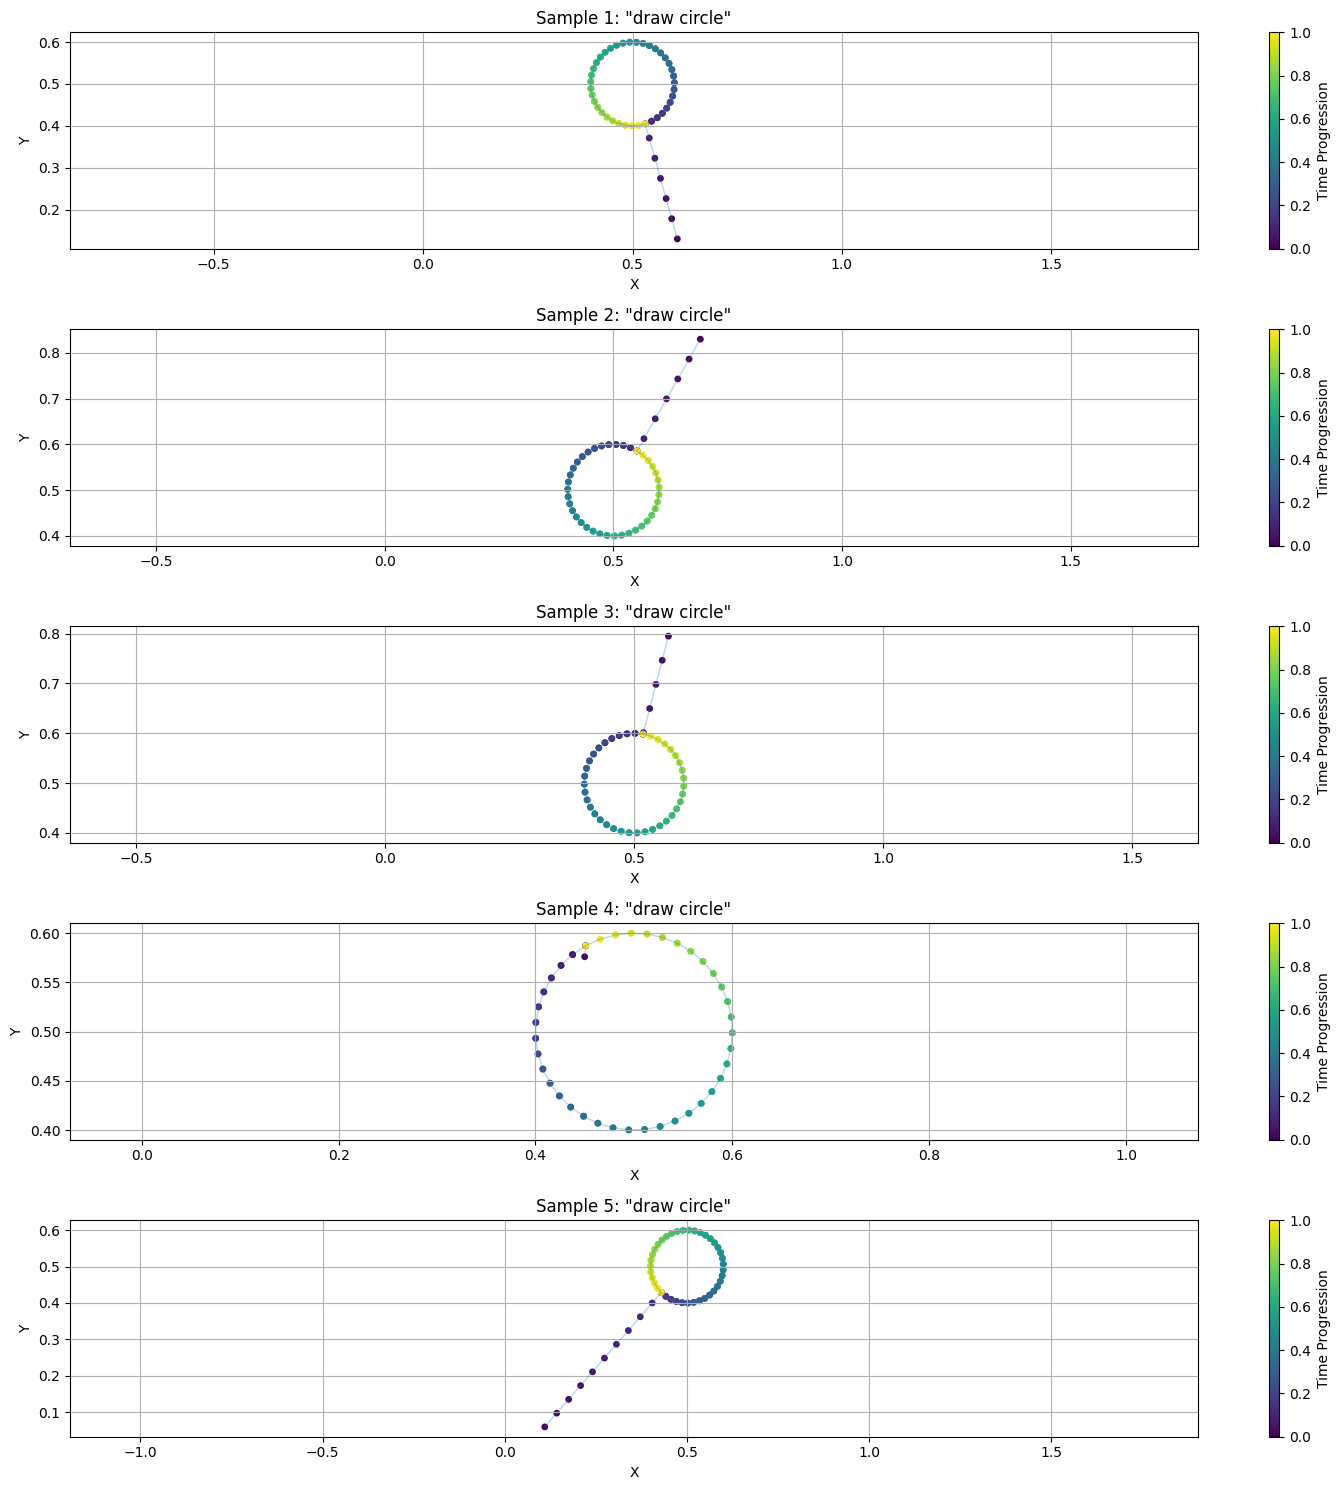

In [160]:
import matplotlib.pyplot as plt

# Visualize a few paths
num_to_plot = 5
plt.figure(figsize=(15, 3 * num_to_plot))

for i in range(num_to_plot):
    path, text = dataset[i]
    path_np = path.numpy()

    x, y = path_np[:, 0], path_np[:, 1]
    time = np.linspace(0, 1, len(x))

    plt.subplot(num_to_plot, 1, i+1)
    scatter = plt.scatter(x, y, c=time, cmap='viridis', s=15)
    plt.plot(x, y, linewidth=1, alpha=0.3)
    plt.title(f"Sample {i+1}: \"{text}\"")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.colorbar(scatter, label="Time Progression")
    plt.axis("equal")
    plt.grid(True)

plt.tight_layout()
plt.show()

# 3. Training

In [140]:

import torch
from LangPathModel.colab_src.nn import TrajectoryModel
from LangPathModel.colab_src.textEncoders import TextEncoder
from torch.optim.lr_scheduler import StepLR

#data = [Batch, sequence, (batch input, batch target)]

def train(model, dataloader, niter, device, start_lr = 1e-4):
    criterion = model.get_loss  # assumes it returns CrossEntropyLoss with ignore_index for padding
    optimizer = torch.optim.SGD(model.parameters(), lr=start_lr)
    num_batches = len(dataloader)
    #print(f"Number of batches: {num_batches}")
    Scheduler = StepLR(optimizer, step_size = 2, gamma=0.1)
    model.positional_encoding = model.positional_encoding.to(device)
    # The model is already defined outside the train function, no need to redefine it here
    # model = TrajectoryModel()
    model.train()
    text_encoder = TextEncoder(output_dim=model.d_model)
    text_encoder.to(device) # Move text_encoder to the device

    for epoch in range(niter):
        total_loss = 0
        index = 0
        for batch_paths, batch_texts in dataloader:
            #print(f"paths: {batch_paths[0]}")
            batch_paths = batch_paths.to(device).float()
            #print(type(batch_paths))
            # Shift target for teacher forcing
            decoder_input = batch_paths[:, :-1].to(device)      # all except last token, move to device
            target_output = batch_paths[:, 1:].to(device)        # all except first token, move to device
            encoder_input = batch_paths[:, 0].unsqueeze(1).to(device) # Move encoder_input to the device
            #print(target_output)

            encoder_input_mask = (encoder_input.abs().sum(dim=-1) != 0).int().reshape(-1, 1).to(device) # Move encoder_input_mask to the device
            #print(f"encoder_input_mask: {encoder_input_mask.shape}")
            #print(f"encoder_input: {encoder_input.shape}"
            emb_text = text_encoder(batch_texts['input_ids'].to(device), batch_texts['attention_mask'].to(device)) # Pass tensors on the device
            text_mask = batch_texts['attention_mask'] == 0

            optimizer.zero_grad()
            #print(f"encoder input mask: {encoder_input_mask.shape}")
            #print(f"encoder_input: {encoder_input.shape}")

            emb_text = emb_text.to(device).float()
            text_mask = text_mask.to(device).bool()

            predictions = model(emb_text = emb_text, path = encoder_input, path_mask = encoder_input_mask, tgt = decoder_input, text_mask=text_mask)  # shape: [B, T]
            # Reshape for loss: CrossEntropy wants [B*T, vocab_size] vs [B*T]

            #predictions = predictions.reshape(-1, predictions.size(-1))
            #print("predictions:", predictions.shape)        # should be [32, 199, 512]
            #print("target_output:", target_output.shape)    # should be the same

            loss = criterion(predictions, target_output)#fix this
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            #print(loss.item())
            #print(index)


        Scheduler.step()
        print(f"Epoch {epoch+1} | Loss: {(total_loss/num_batches):.4f}")

In [161]:
import torch
import torch.utils

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from LangPathModel.colab_src.nn import TrajectoryModel

#from LangPathModel.colab_src.dataset_preprocessing import CirclePathDataset, collate_fn

# Instantiate the dataset
dataset = CirclePathDataset("/content/LangPathModel/data/circle_in_the middle.pt")


# Create a DataLoader with the custom collate_fn
dataloader = DataLoader(dataset, batch_size=50, collate_fn=collate_fn, shuffle=True)

model = TrajectoryModel(d_model = 128)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)
for name, param in model.named_parameters():
    print(f"{name}: {param.device}")


train(model = model, niter = 10, dataloader = dataloader, device = device, start_lr = 1e-4)
model.to('cpu')
torch.save(model.state_dict(), 'model_state_dict.pth')


cuda
input_embedding.weight: cuda:0
input_embedding.bias: cuda:0
encoder.layers.0.self_attn.in_proj_weight: cuda:0
encoder.layers.0.self_attn.in_proj_bias: cuda:0
encoder.layers.0.self_attn.out_proj.weight: cuda:0
encoder.layers.0.self_attn.out_proj.bias: cuda:0
encoder.layers.0.linear1.weight: cuda:0
encoder.layers.0.linear1.bias: cuda:0
encoder.layers.0.linear2.weight: cuda:0
encoder.layers.0.linear2.bias: cuda:0
encoder.layers.0.norm1.weight: cuda:0
encoder.layers.0.norm1.bias: cuda:0
encoder.layers.0.norm2.weight: cuda:0
encoder.layers.0.norm2.bias: cuda:0
decoder.layers.0.self_attn.in_proj_weight: cuda:0
decoder.layers.0.self_attn.in_proj_bias: cuda:0
decoder.layers.0.self_attn.out_proj.weight: cuda:0
decoder.layers.0.self_attn.out_proj.bias: cuda:0
decoder.layers.0.multihead_attn.in_proj_weight: cuda:0
decoder.layers.0.multihead_attn.in_proj_bias: cuda:0
decoder.layers.0.multihead_attn.out_proj.weight: cuda:0
decoder.layers.0.multihead_attn.out_proj.bias: cuda:0
decoder.layers.0.

tensor([[ 0.5280, -0.3768,  0.6924,  0.2951]], device='cuda:0')
tensor([[ 0.5568, -0.1640,  0.6424,  0.3802]], device='cuda:0')
tensor([[ 0.5536, -0.1285,  0.6865,  0.4365]], device='cuda:0')
tensor([[ 0.5956, -0.0216,  0.7310,  0.4917]], device='cuda:0')
tensor([[0.6453, 0.1003, 0.7743, 0.5407]], device='cuda:0')
tensor([[0.6871, 0.1828, 0.7788, 0.5798]], device='cuda:0')
tensor([[0.6881, 0.2281, 0.7558, 0.6170]], device='cuda:0')
tensor([[0.6520, 0.2424, 0.7158, 0.6546]], device='cuda:0')
tensor([[0.6090, 0.2527, 0.6656, 0.6769]], device='cuda:0')
tensor([[0.5779, 0.2533, 0.6377, 0.6767]], device='cuda:0')
tensor([[0.5856, 0.2597, 0.6556, 0.6577]], device='cuda:0')
tensor([[0.6357, 0.2825, 0.7121, 0.6449]], device='cuda:0')
tensor([[0.7059, 0.3064, 0.7850, 0.6570]], device='cuda:0')
tensor([[0.7437, 0.2997, 0.8515, 0.6782]], device='cuda:0')
tensor([[0.7372, 0.2767, 0.8892, 0.7076]], device='cuda:0')
tensor([[0.7262, 0.2318, 0.8741, 0.7247]], device='cuda:0')
tensor([[0.7055, 0.1788,

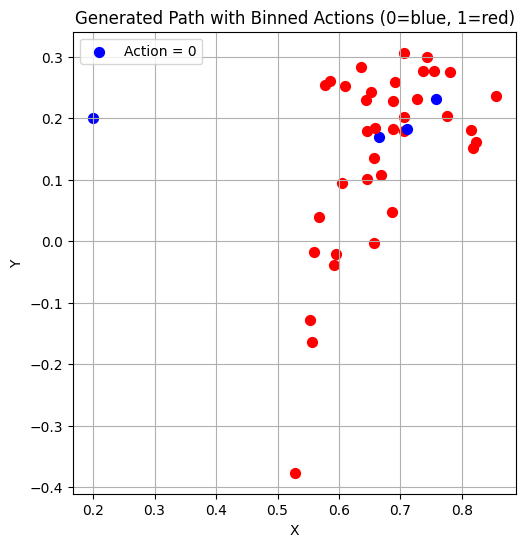

In [180]:
import torch
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
from LangPathModel.colab_src.textEncoders import TextEncoder
from transformers import AutoTokenizer
d_model = 128
model = TrajectoryModel(d_model = d_model)  # Use the same args as when saving

# Step 2: Load the saved state dict
model.load_state_dict(torch.load("model_state_dict.pth", map_location='cuda' if torch.cuda.is_available() else 'cpu'))

# Step 3: Move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.positional_encoding = model.positional_encoding.to(device) # This line was added

# Initialize tokenizer and encoder
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
text_encoder = TextEncoder(output_dim=d_model)


# Text and encoding
text = "draw circle"
encoded = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
txt = text_encoder(encoded['input_ids'], encoded['attention_mask'])

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
txt = txt.to(device)
txt_mask = (encoded['attention_mask'] == 0).to(device)

path_mask = torch.Tensor([[1]]).to(device)

# Iniptialize starting point
start = torch.Tensor([[[0.2, 0.2, 0, 0]]]).to(device)  # (1, 1, 4)
tgt = torch.empty([1, 1, 4]).to(device)  # (1, 1, 4)
# Store predictions
positions = [start[0, 0, :2].clone().cpu().numpy()]

# Loop to generate 100 predictions
for i in range(40):
    with torch.no_grad():
        prediction = model(
            emb_text=txt,
            path=start,
            tgt=tgt,
            text_mask=txt_mask,
            path_mask=path_mask
        )  # Output shape: (1, seq_len+1, 4
    next_point = prediction[:, -1, :]  # Get the last predicted point
    print(next_point)
    positions.append(next_point[0, :2].cpu().numpy())  # Save (x, y)

    # Append next_point to tgt for next prediction
    tgt = torch.cat([tgt, next_point.unsqueeze(1)], dim=1)

# Convert predictions to numpy array
positions = np.array(positions)  # shape: (num_points, 2)
actions = tgt[0, :, 2].cpu().numpy()  # shape: (num_points,) - only 'a' values
print(positions)
# Bin actions
binned_actions = (actions >= 0.5).astype(int)  # 0 if a < 0.5, 1 otherwise

# Plot
plt.figure(figsize=(8, 6))
for i in range(len(positions)):
    x, y = positions[i]
    if binned_actions[i] == 0:
        plt.scatter(x, y, color='blue', label='Action = 0' if i == 0 else "", s=50)
    else:
        plt.scatter(x, y, color='red', label='Action = 1' if i == 0 else "", s=50)

plt.title("Generated Path with Binned Actions (0=blue, 1=red)")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.gca().set_aspect('equal')
plt.grid(True)
plt.show()

